# Relative Diffusivity

## Generating the Network, adding Geometry and creating Phases

This example is about calculation of relative diffusivity of phases in a multiphase transport. The term **relative** indicates the existence of another phase in the medium. The concept of relative property (permeability) in multiphase transport was applied in __[relative permeability example](https://github.com/PMEAL/OpenPNM/tree/examples_galore/examples/notebooks/algorithms/multiphase)__ for a flow problem. In this example the transport mechanism is defined as diffusion. Start by importing OpenPNM and some other useful packages:

In [1]:
import numpy as np
import openpnm as op
%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt
%matplotlib inline
ws = op.Workspace()
np.random.seed(10)
ws.settings["loglevel"] = 40
np.set_printoptions(precision=5)

Next create a **Network** object with a cubic topology and lattice spacing of 25 microns and add boundary pores. A ``SpheresAndCylinders`` **Geometry** is then assgined to the network. This class applies randomly distributed pore and throat sizes to the internal pores. Note that based on the specific problem you can assign a separate geometry to boundary pores as well. The ``Boundary`` class is suitable for boundary pores because of its predifined properties for boundaries such as 0 volume and length. Once the geometry is defined, we then create two phases of ``air`` and ``water``.

In [2]:
pn = op.network.Cubic(shape=[20, 20, 20], spacing=25e-6)
geom = op.geometry.SpheresAndCylinders(network=pn, pores=pn.Ps, throats=pn.Ts)
air = op.phases.Air(network=pn, name='air')
water = op.phases.Water(network=pn, name='water')

AttributeError: module 'openpnm' has no attribute 'phases'

## Define the Pore-Scale Physics

For this simulation the **Standard** physics object can be used as it contains capillary pressure for use in the percolation algorithm and diffusive conductance for use in the ``FickianDiffusion`` algorithm.

In [3]:
phys_air = op.physics.Standard(network=pn, phase=air, geometry=geom)
phys_water = op.physics.Standard(network=pn, phase=water, geometry=geom)

NameError: name 'air' is not defined

## Set up and run the Percolation Algorithm
In order to simulate a partially saturated material we first invade some non-wetting phase.  This will be accomplished using the ``InvasonPercolation`` or ``OrdinaryPercolation`` **Algorithm**. In both algorithms the invading phase invades the network based on the capillary pressure of the throats in the network. These two algorithms have difference in their percolation algorithm and results. The results that we are going to work with are the pores and throats occupancies and saturation of phases. These can be obtained from both methods. If we choose IP, occupancies can be directly extracted from the results for a saturation point. If we choose OP, occupancies and saturation can be extracted from the results for a capillary pressure point. Here, we choose OP algorithm to provide an example of how to work with OP results and saturation.

In [4]:
OP_1 = op.algorithms.OrdinaryPercolation(network=pn, phase=water)
OP_1.set_inlets(pn.pores('left'))
OP_1.run()

NameError: name 'water' is not defined

Note that the results of OP provides the array of occupancies (0 and 1) for the invading phase at a given capillary pressure. The air occupancies are then found as following:

In [5]:
water.update(OP_1.results(Pc=10000))
air['pore.occupancy'] = 1 - water['pore.occupancy']
air['throat.occupancy'] = 1 - water['throat.occupancy']

NameError: name 'water' is not defined

## Run a Fickian Diffusion Algorithm for each step of the invasion process

We now need to model how the presence of the phases affects the diffusive conductivity of the network. Currently the **Physics** objects have a property called ``throat.diffusive_conductance`` but this model does not account for the occupancy of each phase and assumes that the phase occupies every pore-throat-pore conduit. OpenPNM has a number of multiphase models including a conduit conductance that multiplies the single phase conductance by a factor (default 0.000001) when the phase associated with the physics object is not present. The model has a mode which defaults to 'strict' which applies the conductivity reduction if any one of the connected pores or connecting throat is unoccupied.

In [6]:
import openpnm.models.physics as pm
phys_air.add_model(model=pm.multiphase.conduit_conductance,
                   propname='throat.conduit_diffusive_conductance',
                   throat_conductance='throat.diffusive_conductance')
phys_water.add_model(model=pm.multiphase.conduit_conductance,
                     propname='throat.conduit_diffusive_conductance',
                     throat_conductance='throat.diffusive_conductance')

NameError: name 'phys_air' is not defined

Now for each invasion step we cycle through the principle directions and create ``FickianDiffusion`` objects for each phase and calculate the effective diffusivity.  First we create some variables to store our data in for each principle direction (x, y, z). The boundary planes at each side of the domain are used as boundary pores for the Diffusion algorithm. The ```results``` method updates the two **Phase** objects with the occupancy at the given capillary pressure (Pc). The **Physics** objects are then regenerated to re-calculate the ```conduit_diffusive_conductance``` property. Note that for each pressure point, the saturation of a phase is found by ratio of the total volume of pores and throats that are occupied by that phase to the bulk volume of the network.

In [7]:
bounds = [['front', 'back'], ['left', 'right'], ['top', 'bottom']]
diff_air = {'0': [], '1': [], '2': []}
diff_water = {'0': [], '1': [], '2': []}
sat= []
tot_vol = np.sum(pn["pore.volume"]) + np.sum(pn["throat.volume"])
for Pc in np.unique(OP_1['pore.invasion_pressure']):
    water.update(OP_1.results(Pc=Pc))
    air['pore.occupancy'] = 1 - water['pore.occupancy']
    air['throat.occupancy'] = 1 - water['throat.occupancy']
    phys_air.regenerate_models()
    phys_water.regenerate_models()
    this_sat = 0
    this_sat += np.sum(pn["pore.volume"][water["pore.occupancy"] == 1])
    this_sat += np.sum(pn["throat.volume"][water["throat.occupancy"] == 1])
    sat.append(this_sat)
    for bound_increment in range(len(bounds)):
        BC1_pores = pn.pores(labels=bounds[bound_increment][0])
        BC2_pores = pn.pores(labels=bounds[bound_increment][1])
        FD_1 = op.algorithms.FickianDiffusion(network=pn, phase=air)
        FD_1.settings['conductance'] ='throat.conduit_diffusive_conductance'
        FD_1.set_value_BC(values=0.6, pores=BC1_pores)
        FD_1.set_value_BC(values=0.2, pores=BC2_pores)
        FD_1.run()
        R=FD_1.rate(pores=BC1_pores)
        L=0.25e-3
        A=2.5e-3
        eff_diff = np.sum(R) * L / A / (0.6-0.2)
        diff_air[str(bound_increment)].append(eff_diff)
        FD_2 = op.algorithms.FickianDiffusion(network=pn, phase=water)
        FD_2.settings['conductance'] ='throat.conduit_diffusive_conductance'
        FD_2.set_value_BC(values=0.6, pores=BC1_pores)
        FD_2.set_value_BC(values=0.2, pores=BC2_pores)
        FD_2.run()
        R=FD_2.rate(pores=BC1_pores)
        eff_diff = np.sum(R) * L / A / (0.6-0.2)
        diff_water[str(bound_increment)].append(eff_diff)
        pn.project.purge_object(FD_1)
        pn.project.purge_object(FD_2)

NameError: name 'OP_1' is not defined

## Plot the Relative Diffusivity Curves for each direction and Phase

Now we convert the data to Numpy arrays for fast and easy plotting. The relative diffusivity values of each phase is the ratio of its effective diffusivity over its effective diffusivity for f

In [8]:
sat = np.asarray(sat)
sat /= tot_vol
rel_diff_air_x    =  np.asarray(diff_air['0'])
rel_diff_air_x   /=  rel_diff_air_x[0]
rel_diff_air_y    =  np.asarray(diff_air['1'])
rel_diff_air_y   /=  rel_diff_air_y[0]
rel_diff_air_z    =  np.asarray(diff_air['2'])
rel_diff_air_z   /=  rel_diff_air_z[0]
rel_diff_water_x  =  np.asarray(diff_water['0'])
rel_diff_water_x /=  rel_diff_water_x[-1]
rel_diff_water_y  =  np.asarray(diff_water['1'])
rel_diff_water_y /=  rel_diff_water_y[-1]
rel_diff_water_z  =  np.asarray(diff_water['2'])
rel_diff_water_z /=  rel_diff_water_z[-1]

IndexError: index 0 is out of bounds for axis 0 with size 0

Finally plot the relative diffusivity curves for both phases:

NameError: name 'rel_diff_air_y' is not defined

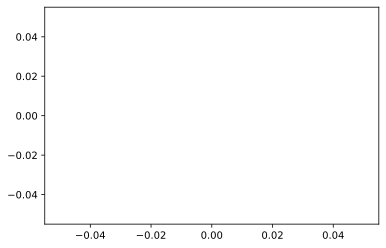

In [9]:
f = plt.figure()
ax = f.add_subplot(111)
ax.plot(sat, rel_diff_air_x, '^-r', label='Dr_a_x')
ax.plot(sat, rel_diff_air_y, '^-g', label='Dr_a_y')
ax.plot(sat, rel_diff_air_z, '^-b', label='Dr_a_z')
ax.plot(sat, rel_diff_water_x, '*-r', label='Dr_w_x')
ax.plot(sat, rel_diff_water_y, '*-g', label='Dr_w_y')
ax.plot(sat, rel_diff_water_z, '*-b', label='Dr_w_z')
ax.set_xlabel('Snw')
ax.set_ylabel('rel_diff')
ax.set_title('Relative Diffusivity Curves')
plt.legend();